In [18]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
from nltk import bigrams as nltk_bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import MWETokenizer
import nltk
from scipy.stats import chi2
from nltk.corpus import stopwords
from functools import lru_cache
from wordcloud import WordCloud
import random

sns.set_style("darkgrid")
nltk.download('stopwords')
nltk.download('wordnet')

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rune\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rune\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Final project - Computational Social Science (02476)

> **Github repository**: [CSS Exam project](https://github.com/runeharlyk/CSS-02467-exam-project)
>
> **Link to website**: [Amazon Reviews Analysis](https://runeharlyk.github.io/CSS-02467-exam-project/)
>
> **Group members**:
> - Rune Harlyk (s234814)
> - Joseph Nguyen (s234826)
> - Julius Winkel (s234862)

We have all worked together on the code and answering questions

## 0. Table of Contents  
[1. Motivation](#1-motivation)  
[2. Statistics](#2-statistics)  
 [2.1 Process meta data](#21-process-meta-data)  
 [2.2 Process review data](#22-process-review-data)  
 [2.3 Final dataset statistics](#23-final-dataset-statistics)  
[3. Tools, Theory, and Analysis](#3-tools-theory-and-analysis)  
 [3.1 Network](#31-network)  
 [3.2 Graph](#32-graph)  
 [3.3 Community detection](#33-community-detection)  
 [3.4 Preparing text](#34-preparing-text)  
 [3.5 Tokens](#35-tokens)  
 [3.6 TF-IDF](#36-tf-idf)  
 [3.7 Word clouds](#37-word-clouds)  
[4. Discussion](#4-discussion)

## 1. Motivation

This project uses an Amazon movie and TV review dataset. It is about 8.2GB for the main dataset and about 1.3GB for the meta dataset. It contains different types of physical media from Amazons web shop and digital streaming from Prime video. The media contains not only movies, documentaries and TV series but also a diverse range of video content, such as cookbooks and fitness programs. The main features for this projects will be:

- "title", movie or TV title for product
- "asin", unique internal Amazon product id
- "parent_asin", internal Amazon product id that covers small product variations in product
- "user_id", Amazon customers who have reviewed a product
- "text", review of a product
- "verified_purchase", Amazon has verified the review if the user has bought the product
- "average_rating", average rating for a movie

The dataset was chosen as it was a large comprehensive dataset of movies and other media with title, users and reviews. 
The goal of this project is to group movies and TV shows in a way that goes beyond standard genres. 
By using graph theory and TF-IDF based word clouds, we will discover if there is any structure in the way people consume media or if peoples' taste are too diverse. 
This also creates an opportunity for consumers to draw inspiration for movies and TV from clusters similar to their own taste and perhaps discover new things to watch.

> Data is available [here](https://amazon-reviews-2023.github.io/)

### Constants and function definitions

In [ ]:
REVIEW_DATA_FILE = 'dataset/Movies_and_TV.jsonl'
META_DATA_FILE = "dataset/meta_Movies_and_TV.jsonl"
EXTENDED_META_DATA_FILE = "dataset/meta_Movies_and_TV_extended.jsonl"

TOKENIZE_REVIEWS_FILE = "dataset/tokenized_reviews.jsonl"
GRAPH_FILE = "graph.gexf"

## 2. Statistics

<!-- Let's understand the dataset better -->

<!-- Write about your choices in data cleaning and preprocessing -->

**Preprocessing of metadata**

Polars framework is the main tool for data frame manipulation. It was chosen over Pandas because we found it far faster and more efficient for large data processing. Most syntax and functions are similar to Pandas.

We start by loading and merging two sets of meta data, using a custom scheme. 
This includes information like title, rating, price.
The extended meta data is manually scraped for the top 12 movies that is missing data, ordered by number of reviews.
The meta data is read from two NDJSON files and merged into a single dataframe.

To clean the data we:

1. Title handling <br>
    1.1 Normalize to unicode with form [NFKD](https://www.unicode.org/reports/tr15/#:~:text=a%20different%20accent.-,Figure%206,-.%20Compatibility%20Composites) <br>
        Preserves meaning by separating base characters and diacritics instead of removing them.
   
    1.2 Remove information in parenthesis, brackets, and season indicators <br>
        Helps unify variations of the same title.

2. Parse price as float. (Fill missing as -1)

3. Description handling.
   Ensure description are a single string

4. Filters rows with missing title

**Preprocessing of helper data**

Now we select best metadata record for each movie title. 
Based on the longest description and most ratings. 
This gives a single canonical version per title with:

 - All asin which represent the same title/movie
 - Single asin to represent the "group"

From this we create two tables. 

- Movies attributes: title, price and average rating (later community)
- ASIN map: A mapping of original ASINs to canonical ASIN. 

**Preprocessing of review**

The review data is filtered such that only verified and helpful reviews are includes.
Unused column are dropped, leaving: rating, text, user_id, timestamp and asin.

Reviews are joined on the ASIN map to ensure that reviews for the same underlying movie or TV show points to the correct canonical item.

**Statistics**

The original dataset contains 17.3 million reviews, 6.5 million unique users and 747.8 thousand movies, TV shows, episodes etc.

After filtering and mapping the final dataset contains 1.6 million reviews, 955.4 thousand unique users, 183 thousand movies, TV shows, episodes etc.

<!-- Write a short section that discusses the dataset stats -->


### 2.1 Process meta data

In [ ]:
schema = {
    "title": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([
        pl.Field("Content advisory", pl.List(pl.Utf8)),
    ]),
    "parent_asin": pl.Utf8,
}

df_meta_1 = pl.read_ndjson(META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})
df_meta_2 = pl.read_ndjson(EXTENDED_META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})

df_meta = pl.concat([df_meta_1, df_meta_2])

# Map prices
df_meta = df_meta.with_columns(
    pl.col("price")
    .str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1)
    .cast(pl.Float64)
    .fill_null(-1)
)

# Map title
df_meta = df_meta.with_columns(
    pl.col("title")
        .str.normalize("NFKD")
        .str.replace_all(r"(?i)\b3-?d\b", "", literal=False)
        .str.replace_all(r"\[.*?\]", "", literal=False)
        .str.replace_all(r"\(.*?\)", "", literal=False)
        .str.replace_all(r":\s*Season\s*\d+", "", literal=False) # Group all seasons
        .str.strip_chars()
        .alias("title")
)

# Map description
df_meta = df_meta.with_columns(
    pl.when(
        pl.col("description").is_null() |
        (pl.col("description").list.eval(pl.element()).list.len() == 0)
    )
    .then(pl.lit([""]).cast(pl.List(pl.Utf8)))
    .otherwise(pl.col("description"))
    .alias("description")
)

df_meta = df_meta.with_columns(
    pl.col("description").list.get(0).alias("description") # TODO GET THE LONGEST DESCRIPTION
)

df_meta = df_meta.with_columns(
    pl.col("description").str.len_chars().alias("desc_len")
)

# Map Content advisory
df_meta = df_meta.with_columns(
    pl.struct(["details"]).map_elements(
        lambda s: s["details"]["Content advisory"] if s["details"] and "Content advisory" in s["details"] else [],
        return_dtype=pl.List(pl.Utf8)
    ).alias("details")
).rename({"details": "content_advisory"})

total_meta_rows = df_meta.height
print(f"There are {total_meta_rows} rows of metadata")

df_meta = df_meta.filter(~pl.col("title").is_null())

print(f"After filtering there are {total_meta_rows - df_meta.height} rows of metadata")

df_meta.limit(3)

There are 748236 rows of metadata
After filtering there are 313988 rows of metadata


shape: (3, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ title     ┆ average_r ┆ rating_nu ┆ descripti ┆ … ┆ categorie ┆ content_a ┆ asin      ┆ desc_len │
│ ---       ┆ ating     ┆ mber      ┆ on        ┆   ┆ s         ┆ dvisory   ┆ ---       ┆ ---      │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ u32      │
│           ┆ f64       ┆ i64       ┆ str       ┆   ┆ list[str] ┆ list[str] ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Glee      ┆ 4.7       ┆ 2004      ┆ Entering  ┆ … ┆ ["Comedy" ┆ ["Violenc ┆ B00ABWKL3 ┆ 396      │
│           ┆           ┆           ┆ its       ┆   ┆ ,         ┆ e", "subs ┆ I         ┆          │
│           ┆           ┆           ┆ fourth    ┆   ┆ "Drama",  ┆ tance     ┆           ┆          │
│           ┆           ┆           ┆ season,   ┆   ┆ … "Music  ┆ use", …   ┆           ┆          │
│           ┆           ┆           ┆ th…       ┆   ┆ V…        ┆           ┆           ┆          │
│ One       ┆ 3.0       ┆ 6         ┆ With her  ┆ … ┆ ["Comedy" ┆ []        ┆ B09WDLJ4H ┆ 219      │
│ Perfect   ┆           ┆           ┆ book tour ┆   ┆ ,         ┆           ┆ P         ┆          │
│ Wedding   ┆           ┆           ┆ in two    ┆   ┆ "Drama",  ┆           ┆           ┆          │
│           ┆           ┆           ┆ week…     ┆   ┆ "Romance" ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ ]         ┆           ┆           ┆          │
│ How to    ┆ 5.0       ┆ 7         ┆ Product   ┆ … ┆ ["Movies  ┆ []        ┆ B00AHN851 ┆ 19       │
│ Make Anim ┆           ┆           ┆ Descripti ┆   ┆ & TV",    ┆           ┆ G         ┆          │
│ atronic   ┆           ┆           ┆ on        ┆   ┆ "Genre    ┆           ┆           ┆          │
│ Charac…   ┆           ┆           ┆           ┆   ┆ for Fea…  ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [21]:
best_per_title = (
    df_meta.sort(["desc_len", "rating_number"], descending=[True, True])
    .group_by("title")
    .agg([
        pl.col("asin").unique().alias("asins"),
        pl.first("asin").alias("asin"), 
        pl.first("average_rating"),
        pl.first("rating_number"),
        pl.first("description"),
        pl.first("price"),
        pl.first("categories"),
        pl.first("content_advisory")
    ])
    .with_columns(
        pl.col("asins").list.len().alias("num_asins")
    )
)
print(best_per_title.height)
best_per_title.sort("num_asins", descending=True).limit(3)

319288


shape: (3, 10)
┌────────────┬────────────┬────────────┬───────────┬───┬───────┬───────────┬───────────┬───────────┐
│ title      ┆ asins      ┆ asin       ┆ average_r ┆ … ┆ price ┆ categorie ┆ content_a ┆ num_asins │
│ ---        ┆ ---        ┆ ---        ┆ ating     ┆   ┆ ---   ┆ s         ┆ dvisory   ┆ ---       │
│ str        ┆ list[str]  ┆ str        ┆ ---       ┆   ┆ f64   ┆ ---       ┆ ---       ┆ u32       │
│            ┆            ┆            ┆ f64       ┆   ┆       ┆ list[str] ┆ list[str] ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════╪═══════════╪═══════════╪═══════════╡
│ Charlie    ┆ ["B000IU35 ┆ B000IU34D2 ┆ 5.0       ┆ … ┆ -1.0  ┆ ["Movies  ┆ []        ┆ 65        │
│ Rose       ┆ TK", "B000 ┆            ┆           ┆   ┆       ┆ & TV",    ┆           ┆           │
│            ┆ JBX0PC",   ┆            ┆           ┆   ┆       ┆ "Charlie  ┆           ┆           │
│            ┆ ……         ┆            ┆           ┆   ┆       ┆ Rose …    ┆           ┆           │
│ The        ┆ ["B00BOL0T ┆ B005LAJ22Q ┆ 4.8       ┆ … ┆ 18.98 ┆ ["Movies  ┆ []        ┆ 59        │
│ Walking    ┆ SM", "6303 ┆            ┆           ┆   ┆       ┆ & TV",    ┆           ┆           │
│ Dead       ┆ 487696",   ┆            ┆           ┆   ┆       ┆ "Boxed    ┆           ┆           │
│            ┆ ……         ┆            ┆           ┆   ┆       ┆ Sets", …  ┆           ┆           │
│ Cinderella ┆ ["63018160 ┆ B00V6C5Z0Q ┆ 4.7       ┆ … ┆ 7.99  ┆ ["Movies  ┆ []        ┆ 58        │
│            ┆ 80", "B000 ┆            ┆           ┆   ┆       ┆ & TV",    ┆           ┆           │
│            ┆ 00K31S",   ┆            ┆           ┆   ┆       ┆ "Walt     ┆           ┆           │
│            ┆ ……         ┆            ┆           ┆   ┆       ┆ Disney S… ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───┴───────┴───────────┴───────────┴───────────┘

In [22]:
movie_attributes = (
    best_per_title.select([
        pl.col("title"),
        pl.col("asins"),
        pl.col("average_rating"),
        pl.col("price")
    ]).explode("asins")
    .rename({"asins": "asin"})
    .sort("title", nulls_last=True)
    .unique(subset=["asin"], keep="first")
)

movie_attributes.limit(3)    

shape: (3, 4)
┌─────────────────────────────────┬────────────┬────────────────┬───────┐
│ title                           ┆ asin       ┆ average_rating ┆ price │
│ ---                             ┆ ---        ┆ ---            ┆ ---   │
│ str                             ┆ str        ┆ f64            ┆ f64   │
╞═════════════════════════════════╪════════════╪════════════════╪═══════╡
│ Broken Silence                  ┆ B0001Y9Z88 ┆ 4.4            ┆ 12.96 │
│ Giants, Midgets, Heroes and Vi… ┆ B0011KQU16 ┆ 4.5            ┆ -1.0  │
│ Disfigured                      ┆ B001A5070W ┆ 4.1            ┆ 12.99 │
└─────────────────────────────────┴────────────┴────────────────┴───────┘

In [23]:
asin_map = (
    best_per_title
      .select(["asin", "asins"])
      .explode("asins")
      .rename({
        "asin": "canon_asin",
        "asins": "orig_asin"
      })
)
asin_map.height

434248

### 2.2 Process review data

In [24]:
filtered_df = (pl.scan_ndjson(REVIEW_DATA_FILE)
    .filter(pl.col('verified_purchase'))
    .filter(pl.col('helpful_vote').gt(0))
    .drop(['images', 'verified_purchase', 'asin', 'helpful_vote', 'title'])
    .rename({'parent_asin': 'asin'})
    .collect()
    .join(asin_map, left_on="asin", right_on="orig_asin", how="inner")
    .drop(["asin"])
    .rename({"canon_asin": "asin"})
)
print(f"Number of ratings: {filtered_df.height}")
filtered_df.limit(1)

Number of ratings: 1641575


shape: (1, 5)
┌────────┬──────────────────────────────┬─────────────────────────────┬───────────────┬────────────┐
│ rating ┆ text                         ┆ user_id                     ┆ timestamp     ┆ asin       │
│ ---    ┆ ---                          ┆ ---                         ┆ ---           ┆ ---        │
│ f64    ┆ str                          ┆ str                         ┆ i64           ┆ str        │
╞════════╪══════════════════════════════╪═════════════════════════════╪═══════════════╪════════════╡
│ 5.0    ┆ This DVD was GREAT!  I am a  ┆ AGXVBIUFLFGMVLATYXHJYL4A5Q7 ┆ 1146713492000 ┆ B0009BXO3K │
│        ┆ st…                          ┆ Q                           ┆               ┆            │
└────────┴──────────────────────────────┴─────────────────────────────┴───────────────┴────────────┘

### 2.3 Final dataset statistics

In [25]:
filtered_df.head(3)

shape: (3, 5)
┌────────┬──────────────────────────────┬─────────────────────────────┬───────────────┬────────────┐
│ rating ┆ text                         ┆ user_id                     ┆ timestamp     ┆ asin       │
│ ---    ┆ ---                          ┆ ---                         ┆ ---           ┆ ---        │
│ f64    ┆ str                          ┆ str                         ┆ i64           ┆ str        │
╞════════╪══════════════════════════════╪═════════════════════════════╪═══════════════╪════════════╡
│ 5.0    ┆ This DVD was GREAT!  I am a  ┆ AGXVBIUFLFGMVLATYXHJYL4A5Q7 ┆ 1146713492000 ┆ B0009BXO3K │
│        ┆ st…                          ┆ Q                           ┆               ┆            │
│ 3.0    ┆ this item was canceled. . .  ┆ AEFKF6R2GUSK2AWPSWRR4ZO36JV ┆ 1556496429981 ┆ B000PIU2A0 │
│        ┆ .n…                          ┆ Q                           ┆               ┆            │
│ 5.0    ┆ I grew up with this one.     ┆ AEFKF6R2GUSK2AWPSWRR4ZO36JV ┆ 1364088518000 ┆ B001JNNDRY │
│        ┆ could…                       ┆ Q                           ┆               ┆            │
└────────┴──────────────────────────────┴─────────────────────────────┴───────────────┴────────────┘

In [26]:
print("Number of unique movies and TV: ", filtered_df.select(pl.col("asin")).unique().height)
print("Number of reviews: ", filtered_df.height)
print("Number of unique reviewers: ", filtered_df.select(pl.col("user_id")).unique().height)

Number of unique movies and TV:  183024
Number of reviews:  1641575
Number of unique reviewers:  955476


## 3. Tools, Theory, and Analysis

<!-- Describe the process of theory to insight -->
This project turns raw review text into insights using natural language processing (NLP) and network analysis. 
Our goal is to find patterns in the movies and TV shows reviewers review.

<!-- Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving. -->

**Network**

NetworkX will be the main tool for graph theory based on a weighted edge list. The network was found to have 10897 nodes and 25988 edges after only included edges with a weight of 3 or higher. 
We choses this threshold as a balance between having a highly dense network and clearly separated communities.
This is a not fully connected network with a density of only 0.000438 after removing low weighted edges. 
The network has a modularity of 0.767 which is very high and it should indicate that there are some distinct communites. 

As the network is quite large [Gephi](https://gephi.org/) was use to visualizes and play with the network. This was also used to manually analyze and annotate the movies based on titles in the clusters.

<!-- Talk This was also used to manually analyze and annotate the movies based on titles in the clusters.This was also used to manually analyze and annotate some of the biggest communities based on the type of movies in them. about how you've worked with text, including regular expressions, unicode, etc. -->

**Natural language processing (NLP)**

To process text, we use NLTK. Each review is cleaned and tokenized usi ng the process below:

1. Normalize to unicode with form [NFKD](https://www.unicode.org/reports/tr15/#:~:text=a%20different%20accent.-,Figure%206,-.%20Compatibility%20Composites) <br>
   Preserves meaning by separating base characters and diacritics instead of removing them.

2. Convert to lowercase

3. Replace HTML line breaks (`<br>`, `<br/>`, etc.) with a space <br>
   This ensure format tags are represented in documents, and by replacing with space we keep word separation 

4. Normalize "blu-ray" variants to `"bluray"` <br >
   Unifies alternate spellings for consistent processing.

5. Remove all non-alphanumeric characters (excluding space) <br >
   Strips punctuation, symbols, and other noise.

6. Collapse multiple spaces into a single space <br >
   Ensures split is not empty

7. Strip leading/trailing whitespace characters

8. Split the cleaned string into tokens (by space)

9. Lemmatize each token (with caching) <br >
   Reduces inflected forms to their base form.

10. Filter out lemmatized stopwords (including custom ones) <br >
   Removes common and domain-specific stop words. <br >
   Examples includes "movie", "film", "episode" and "season" as they do not convey any meaning to the documents


Once we have the cleaned and lemmatized tokens, we use `nltk.bigrams` to pair each word with the next to improve contextual understanding. 
Then, a custom function helps us pick out the most meaningful or frequently used word pairs (collocations). 
To treat these phrases as single units, we use `MWETokenizer`, which joins them together (like turning "star wars" into "star\_wars") so they’re kept intact during analysis.

TF-IDF is computed for the words in each community to find the unique keywords that defines them. 
They are then displayed in word clouds. 


<!-- How did you use the tools to understand your dataset? -->

This approach allowed us to watch communities of movies form from messy unstructured review data.



### 3.1 Network

In [27]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by("user_id")
        .agg(pl.col("asin").unique().alias("asins"))
        .filter(pl.col("asins").list.len() > 1)
    )

    counter = Counter()

    for asins in tqdm(grouped["asins"], desc="Reviewer"):
        counter.update(tuple(sorted(pair)) for pair in combinations(asins, 2))

    return [(a, b, count) for (a, b), count in counter.items()]

In [28]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 221614/221614 [00:10<00:00, 21947.21it/s]


8532787

In [29]:
Counter((w for _, _, w in movie_edgelist))

Counter({1: 8345819,
         2: 160980,
         3: 18125,
         4: 4481,
         5: 1545,
         6: 733,
         7: 378,
         8: 205,
         9: 147,
         10: 83,
         11: 73,
         12: 49,
         13: 36,
         17: 18,
         14: 17,
         19: 16,
         16: 16,
         15: 15,
         18: 8,
         25: 6,
         21: 5,
         23: 4,
         26: 4,
         20: 4,
         27: 3,
         22: 3,
         24: 2,
         35: 2,
         39: 1,
         30: 1,
         50: 1,
         79: 1,
         32: 1,
         84: 1,
         83: 1,
         75: 1,
         40: 1,
         31: 1})

### 3.2 Graph

The graph is created from the weighted edges with an weight of 3 or over.

In [30]:
WEIGHT_THRESHOLD = 3
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

25988

In [31]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price"]
df_attrs = movie_attributes.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}

In [32]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
nx.set_node_attributes(G, attr_dict)

In [33]:
len(G.nodes()), len(G.edges())

(10897, 25988)

In [34]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

4.769753143066899

In [61]:
print('Is the graph connected: ', nx.is_connected(G))
print('Graph density: ', nx.density(G))

Is the graph connected:  False
Graph density:  0.00043775267465738797


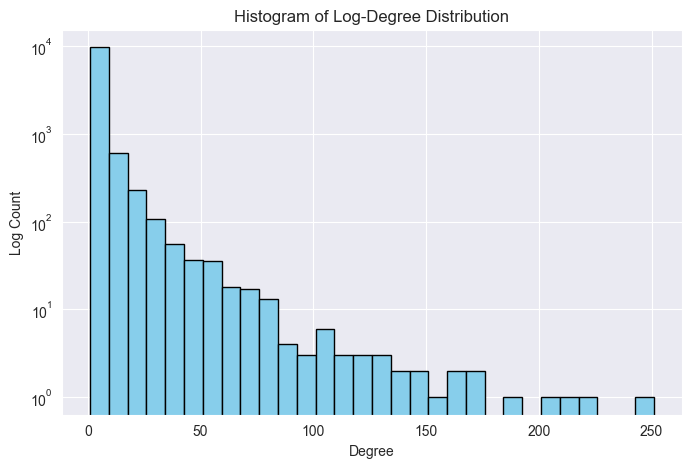

In [36]:
X = list(dict(G.degree).values())
plt.figure(figsize=(8,5))
plt.hist(X, bins=30, color="skyblue", edgecolor="black")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.title("Histogram of Log-Degree Distribution")
plt.show()

### 3.3 Community detection

In [37]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [38]:
def louvain_partitions(G):
    np.random.seed(42)
    random.seed(42)
    partition = community_louvain.best_partition(G, randomize=False, resolution=1)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [39]:
communities = louvain_partitions(G)
Q = modularity(G, communities)
len(communities), Q

(1425, 0.7675985339511785)

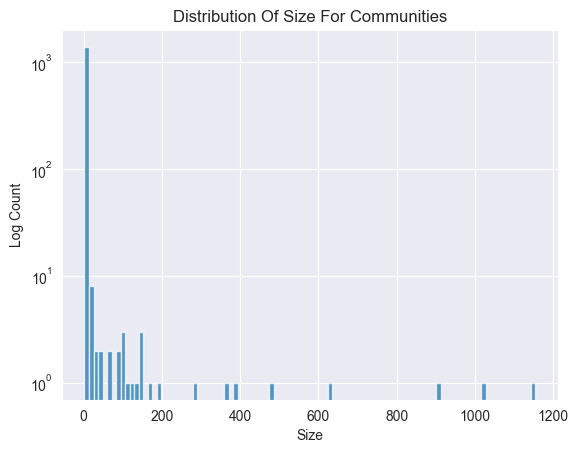

In [40]:
X = list(map(len, communities))
plt.yscale("log")
plt.title("Distribution Of Size For Communities")
plt.xlabel("Size")
plt.ylabel("Log Count")
plt.hist(X, 100, alpha=0.75);

In [41]:
# Adding community labels to the df
movie_to_community = {
    movie_id: i
    for i, com in enumerate(communities)
    for movie_id in com
}

community_df = pl.DataFrame([
    {"asin": k, "community": v}
    for k, v in movie_to_community.items()
])

if "community" in filtered_df.columns:
    filtered_df = filtered_df.drop("community")

filtered_df = filtered_df.join(community_df, on="asin", how="left")
filtered_df = filtered_df.fill_null("")
filtered_df.limit(2)

shape: (2, 6)
┌────────┬────────────────────────┬───────────────────────┬───────────────┬────────────┬───────────┐
│ rating ┆ text                   ┆ user_id               ┆ timestamp     ┆ asin       ┆ community │
│ ---    ┆ ---                    ┆ ---                   ┆ ---           ┆ ---        ┆ ---       │
│ f64    ┆ str                    ┆ str                   ┆ i64           ┆ str        ┆ i64       │
╞════════╪════════════════════════╪═══════════════════════╪═══════════════╪════════════╪═══════════╡
│ 5.0    ┆ This DVD was GREAT!  I ┆ AGXVBIUFLFGMVLATYXHJY ┆ 1146713492000 ┆ B0009BXO3K ┆ 286       │
│        ┆ am a st…               ┆ L4A5Q7Q               ┆               ┆            ┆           │
│ 3.0    ┆ this item was          ┆ AEFKF6R2GUSK2AWPSWRR4 ┆ 1556496429981 ┆ B000PIU2A0 ┆ null      │
│        ┆ canceled. . . .n…      ┆ ZO36JVQ               ┆               ┆            ┆           │
└────────┴────────────────────────┴───────────────────────┴───────────────┴────────────┴───────────┘

In [ ]:
movie_attributes = (
    best_per_title
      .select(["title", "asins", "average_rating", "price"])
      .explode("asins")
      .rename({"asins":"asin"})
      .unique(subset=["asin"])
      .join(community_df, on="asin", how="left")
)

attributes = ["title", "average_rating", "price", "community"]
df_attrs = movie_attributes.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, GRAPH_FILE)

### 3.4 Preparing text

In [43]:
filtered_df.filter(pl.col("community").is_null()).height

981313

In [44]:
filtered_df = filtered_df.filter(pl.col("community").is_not_null()) # Filter reviews that is not part of community - Removed with weight threshold

In [45]:
sum(list(map(len, communities))), len(G.nodes)

(10897, 10897)

In [46]:
# size of each community
community_sizes = (
    filtered_df
    .group_by("community")
    .agg(pl.col("asin").n_unique().alias("community_size"))
    .sort("community_size", descending=True)
)

community_sizes.limit(10)

shape: (10, 2)
┌───────────┬────────────────┐
│ community ┆ community_size │
│ ---       ┆ ---            │
│ i64       ┆ u32            │
╞═══════════╪════════════════╡
│ 3         ┆ 1155           │
│ 2         ┆ 1022           │
│ 0         ┆ 906            │
│ 13        ┆ 630            │
│ 19        ┆ 485            │
│ 7         ┆ 393            │
│ 30        ┆ 366            │
│ 51        ┆ 283            │
│ 20        ┆ 191            │
│ 49        ┆ 173            │
└───────────┴────────────────┘

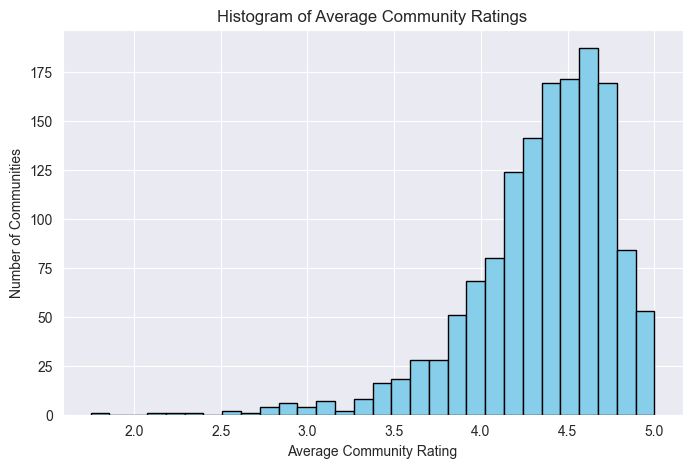

In [47]:
avg_com_rating = (
    filtered_df
    .group_by("community")
    .agg(pl.col("rating").mean())
    .sort("rating")
)
avg_com_rating_dict = {
    row["community"]: round(row["rating"], 1)
    for row in avg_com_rating.to_dicts()
}

plt.figure(figsize=(8,5))
plt.hist(avg_com_rating["rating"].to_list(), bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Average Community Rating")
plt.ylabel("Number of Communities")
plt.title("Histogram of Average Community Ratings")
plt.show()

### 3.5 Tokens

In [ ]:
lemmatizer = WordNetLemmatizer()

custom = {"film","movie","season","episode","3d","bluray","like"} #These words words are added to stop words as they are not useful for analysis
stop_words = set(stopwords.words("english")) | custom

stop_lems = {lemmatizer.lemmatize(w) for w in stop_words}

@lru_cache(maxsize=20000)
def cached_lems(word):
    return lemmatizer.lemmatize(word)

def tokenize(tokens):
    return [s for t in tokens if (s := cached_lems(t)) not in stop_lems]

def bigramify(tokens):
    return list(nltk_bigrams(tokens))

In [49]:
filtered_df = filtered_df.with_columns(
    pl.col("text")
      .str.normalize("NFKC")
      .str.to_lowercase()
      .str.replace_all(r"<br\s*/?>", " ", literal=False)
      .str.replace_all(r"\bblu[\s-]?ray\b", "bluray", literal=False)
      .str.replace_all(r"[^A-Za-z0-9 ]", "")
      .str.replace_all(r"\s+", " ", literal=False)
      .str.strip_chars()           
      .str.split(" ")  
      .map_elements(tokenize, return_dtype=pl.List(pl.Utf8))
      .alias("tokens")
)

In [50]:
filtered_df = filtered_df.with_columns(
    bigrams=pl.col("tokens").map_elements(bigramify, return_dtype=pl.List(pl.List(pl.Utf8)))
)
filtered_df.limit(5)

shape: (5, 8)
┌────────┬────────────┬────────────┬────────────┬────────────┬───────────┬────────────┬────────────┐
│ rating ┆ text       ┆ user_id    ┆ timestamp  ┆ asin       ┆ community ┆ tokens     ┆ bigrams    │
│ ---    ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---        ┆ ---        │
│ f64    ┆ str        ┆ str        ┆ i64        ┆ str        ┆ i64       ┆ list[str]  ┆ list[list[ │
│        ┆            ┆            ┆            ┆            ┆           ┆            ┆ str]]      │
╞════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪════════════╪════════════╡
│ 5.0    ┆ This DVD   ┆ AGXVBIUFLF ┆ 1146713492 ┆ B0009BXO3K ┆ 286       ┆ ["dvd",    ┆ [["dvd",   │
│        ┆ was GREAT! ┆ GMVLATYXHJ ┆ 000        ┆            ┆           ┆ "great", … ┆ "great"],  │
│        ┆ I am a st… ┆ YL4A5Q7Q   ┆            ┆            ┆           ┆ "give"]    ┆ ["great",  │
│        ┆            ┆            ┆            ┆            ┆           ┆            ┆ "…         │
│ 5.0    ┆ I grew up  ┆ AEFKF6R2GU ┆ 1364088518 ┆ B001JNNDRY ┆ 13        ┆ ["grew",   ┆ [["grew",  │
│        ┆ with this  ┆ SK2AWPSWRR ┆ 000        ┆            ┆           ┆ "one", …   ┆ "one"],    │
│        ┆ one.       ┆ 4ZO36JVQ   ┆            ┆            ┆           ┆ "collectio ┆ ["one",    │
│        ┆ could…     ┆            ┆            ┆            ┆           ┆ n"…        ┆ "cou…      │
│ 4.0    ┆ This is a  ┆ AFWHJ6O3PV ┆ 1399992093 ┆ B001JV5BF8 ┆ 297       ┆ ["fun",    ┆ [["fun",   │
│        ┆ fun,       ┆ 4JC7PVOJH6 ┆ 000        ┆            ┆           ┆ "colorful" ┆ "colorful" │
│        ┆ colorful,  ┆ CPULO2KQ   ┆            ┆            ┆           ┆ , …        ┆ ],         │
│        ┆ enter…     ┆            ┆            ┆            ┆           ┆ "imo62"]   ┆ ["colorf…  │
│ 2.0    ┆ Classic    ┆ AEO4M665ZO ┆ 1325272496 ┆ B07FMQXZBD ┆ 0         ┆ ["classic" ┆ [["classic │
│        ┆ movie. But ┆ CBF7HEFRMT ┆ 000        ┆            ┆           ┆ , "didnt", ┆ ",         │
│        ┆ I didn't   ┆ UDHLSB5Q   ┆            ┆            ┆           ┆ … "proble… ┆ "didnt"],  │
│        ┆ ge…        ┆            ┆            ┆            ┆           ┆            ┆ ["didnt…   │
│ 4.0    ┆ This is    ┆ AG35BKPUEU ┆ 1514400490 ┆ B008UY8FI2 ┆ 0         ┆ ["best",   ┆ [["best",  │
│        ┆ the best   ┆ MX7LV5YLOQ ┆ 306        ┆            ┆           ┆ "version", ┆ "version"] │
│        ┆ version    ┆ 5YCQ3GOA   ┆            ┆            ┆           ┆ …          ┆ ,          │
│        ┆ follo…     ┆            ┆            ┆            ┆           ┆ "station…  ┆ ["versio…  │
└────────┴────────────┴────────────┴────────────┴────────────┴───────────┴────────────┴────────────┘

In [51]:
bigrams = (
    filtered_df
    .select(pl.col("bigrams"))
    .drop_nulls()
    .explode("bigrams")
    .get_column("bigrams")
    .to_list()
)

bigrams = [tuple(bg) for bg in bigrams if isinstance(bg, list) and len(bg) == 2]

filtered_df = filtered_df.drop("bigrams")

In [52]:
def find_collocations(bigrams, min_count=50, p_threshold=0.001):
    bigram_counts = Counter(bigrams)
    first_counts = Counter()
    second_counts = Counter()
    for (w1, w2), cnt in bigram_counts.items():
        first_counts[w1] += cnt
        second_counts[w2] += cnt

    N = len(bigrams)
    items = list(bigram_counts.items())
    bgs, nii = zip(*items)
    w1s, w2s = zip(*bgs)

    f = np.fromiter((first_counts[w] for w in w1s), float)
    s = np.fromiter((second_counts[w] for w in w2s), float)
    o = np.array(nii, float)

    nio = f - o
    noi = s - o
    noo = N - (o + nio + noi)

    Eii = f * s / N
    Eio = f * (N - s) / N
    Eoi = (N - f) * s / N
    Eoo = (N - f) * (N - s) / N

    chi2_vals = (o - Eii)**2/Eii + (nio - Eio)**2/Eio + (noi - Eoi)**2/Eoi + (noo - Eoo)**2/Eoo
    p_vals = chi2.sf(chi2_vals, 1)

    mask = (o > min_count) & (p_vals < p_threshold)
    return {bgs[i]: int(o[i]) for i in np.nonzero(mask)[0]}

collocs = find_collocations(bigrams)

In [53]:
tokenizer = MWETokenizer(list(collocs.keys()), separator="_")
filtered_df = filtered_df.with_columns(
    tokens=pl.col("tokens").map_elements(tokenizer.tokenize, return_dtype=pl.List(pl.Utf8))
)

In [ ]:
# filtered_df.write_ndjson(TOKENIZE_REVIEWS_FILE)
# filtered_df = pl.read_ndjson(TOKENIZE_REVIEWS_FILE)

In [55]:
community_docs = (
    filtered_df
    .group_by("community")
    .agg(
        pl.concat_list("tokens").flatten().alias("tokens"), 
        pl.len().alias("num_reviews")
    ).sort("num_reviews", descending=True)
)
top5com = community_docs.limit(20)

### 3.6 TF-IDF

TF-IDF was choosen as it will weight how many times a word appears in a cluster compared to the whole dataset corpus. It should give some unique key words for each cluster.

In [56]:
def calculate_tf(tokens):
    total = len(tokens)
    counts = Counter(tokens)
    return {word: count / total for word, count in counts.items()}

def calculate_idf(docs: pl.DataFrame) -> dict[str, float]:
    N = docs.height
    df = (
        docs
        .explode("tokens")
        .unique(subset=["community", "tokens"])
        .group_by("tokens")
        .agg(pl.len().alias("df"))
        .with_columns((pl.lit(N) / pl.col("df")).log().alias("idf"))
        .sort("idf", descending=False)
    )
    return dict(zip(df["tokens"].to_list(), df["idf"].to_list()))

def calculate_tf_idf(tf, idf):
    tf_idf = {}
    for word, val in tf.items():
        tf_idf[word] = val * idf[word]
    return tf_idf

In [57]:
idf = calculate_idf(community_docs)

In [58]:
top_5_tf_idf = dict(zip(
    top5com["community"].to_list(),
    [calculate_tf_idf(calculate_tf(toks), idf) for toks in top5com["tokens"].to_list()]
))

In [59]:
top_titles = (filtered_df.join(
      movie_attributes.select(["asin","title"]),
      on="asin",
      how="left"
   ).group_by(["community", "title"])
    .agg(pl.len().alias("count"))
    .sort(["community","count"], descending=[False,True])
    .group_by("community")
    .agg(pl.col("title").head(3).alias("top_titles"))
)

top_titles_dict = dict(zip(top_titles["community"].to_list(), top_titles["top_titles"].to_list()))

### 3.7 Word clouds

Word clouds are based on TF-IDF and are vizualized for some of the biggest communities in the dataset. They should display some of the unique key words that define each cluster.

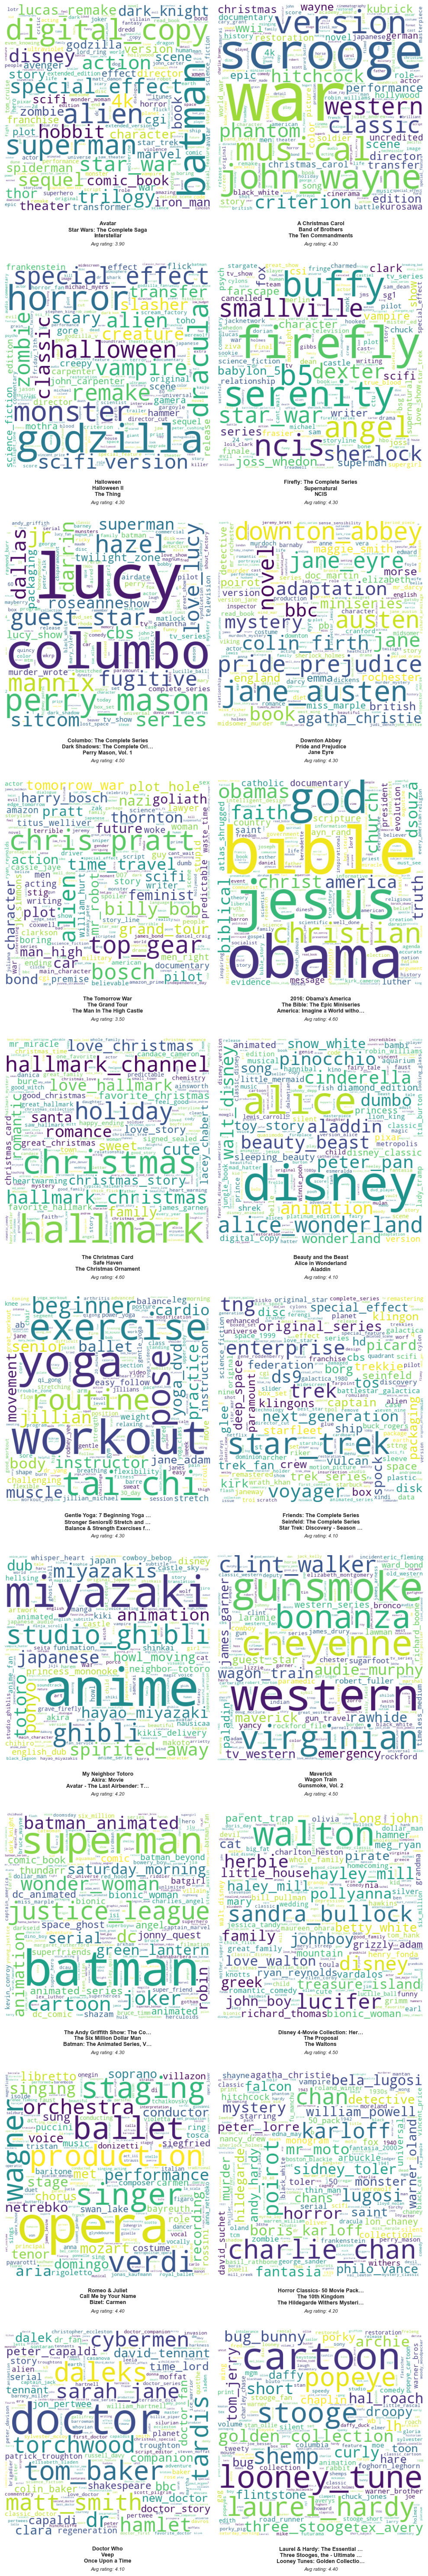

In [60]:
def plot_word_clouds_grid(word_freq, top_movies=None, average_rating=None, ncols=2, max_title_len=30):
    def truncate_list(ts):
        return [t if len(t) <= max_title_len else t[:max_title_len] + '…' for t in ts]

    communities = list(word_freq.keys())
    nrows = -(-len(communities) // ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 6))
    axes = axes.flatten()

    for i, (ax, comm) in enumerate(zip(axes, communities)):
        cloud = WordCloud(background_color='white', height=500, width=500, colormap="viridis_r", contour_color='black', contour_width=0.5)
        cloud.generate_from_frequencies(word_freq[comm])

        ax.imshow(cloud, interpolation='bilinear')
        ax.axis('off')

        titles = truncate_list(top_movies.get(comm, []))
        rating = average_rating.get(comm, -1)
        movie_text = "\n".join(titles)
        ax.text(0.5, -0.05, movie_text, transform=ax.transAxes, fontsize=9, ha='center', va='top', fontweight='bold')
        ax.text(0.5, -0.15, f"Avg rating: {rating:.2f}", transform=ax.transAxes, fontsize=8, ha='center', va='top', style='italic')

        plt.figure(figsize=(5, 5))
        plt.imshow(cloud, interpolation='bilinear')
        plt.axis('off')
        plt.text(0.5, -0.05, movie_text, transform=plt.gca().transAxes, fontsize=9, ha='center', va='top', fontweight='bold')
        plt.text(0.5, -0.15, f"Avg rating: {rating:.2f}", transform=plt.gca().transAxes, fontsize=8, ha='center', va='top', style='italic')
        plt.tight_layout()

        plt.savefig(f"website/assets/{i}_wordcloud.png", dpi=150)
        plt.close()

    for ax in axes[len(communities):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_word_clouds_grid(top_5_tf_idf, top_titles_dict, avg_com_rating_dict)

## 4. Discussion

Based on the word clouds, the clustering actual seems to create some unique communities. Some of the largest communities might not be as distinct as they contain a larger selection of popular movies that are well connected. There are also communities that overlap, where distinctions between them are more nuanced. At the same time, really niche and distinct communities such as the fitness or classical music community are also present. Another distinctive community is one that contains mostly Amazon Prime original content, which makes sense as some consumers might stay within the Amazon eco-system. Overall, we have got an interesting insight into how people consume media, but it is also a limitation of the dataset when looking at what types of movies that are connected.

It was hard to determine how aggressive the filtering of titles should be. Everything in brackets, blu-ray and parenthesis was dropped in order to merge title duplicates, but there are many different permutations of the same title. Over-filtering risks merging titles that are actual different products. Also different entries in a movie series should be distinct but seasons in a TV show are more of a grey zone. For community detection, different seasons of a TV show will hopefully be clustered together, so the reviews will go to the same cluster corpus anyways. Nodes that are larger than the rest of the community might dominate the word cloud, which can create some key words that do not represent the whole community. The edges are also only based on what people review and not everything they buy or watch, but there should be some correlation.

Overall the clustering and text analysis seemed successful as the communities had mostly distinct key words. While a singular consumer might have some irregular or diverse viewing habits, it will still cluster together when averaged over many people and taking weights into consideration. The key words reveals some interesting patterns that expand on traditional genres. One is about christianity, America and politics, which could be a conservative traditional theme. Another is about LGBTQ+ and homosexual relationalships which are more liberal themes. 